In [6]:
import os

from dotenv import load_dotenv
from pprint import pprint

from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import ChatOpenAI


True

### Chat Model

Here, we use OpenAI chat models. First, you need to have the api key `OPENAI_API_KEY`.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) model. Two most commonly used are:
* `gpt-3.5-turbo-0125` - low price
* `gpt-4o` -  it's a good balance of quality, price, and speed

There are [a few standard parameters](https://python.langchain.com/v0.2/docs/concepts/#chat-models) that we can set with chat models. Two of the most common are:

* `model`: the name of the model
* `temperature`: the sampling temperature

`Temperature` controls the randomness or creativity of the model's output where low temperature (close to 0) is more deterministic and focused outputs. This is good for tasks requiring accuracy or factual responses. High temperature (close to 1) is good for creative tasks or generating varied responses.

In [7]:
# set the openai api key (it has been save in a file called '.env')
load_dotenv()

llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)

In [19]:
# define a tool (perform a specific task)
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# it connect the LLM to the tool.
# LLM decides when to use this tool (whenever LLM finds it appropriate, it use the tool)
llm_with_tools = llm.bind_tools([multiply])

### Messages

Chat models accepts a sequence of messages from different roles within a conversation.

Each message consists of:
* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

LangChain supports various message types, including:
* `HumanMessage` - a message from the user
* `AIMessage` - a message from the chat model
* `SystemMessage` - a message for the chat model to instruct its behavior
* `ToolMessage` - a message from a tool call.

In [5]:
messages = [AIMessage(content=f"So you want to know more about Einstein. What exactly do you want to know?", name="llm")]
messages.append(HumanMessage(content=f"I want to know in which field he worked.",name="Mohammad"))
messages.append(AIMessage(content=f"He was a physicist.", name="llm"))
messages.append(HumanMessage(content=f"Ok. Why is he so famous? .", name="Mohammad"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: llm

So you want to know more about Einstein. What exactly do you want to know?
================================ Human Message =================================
Name: Mohammad

I want to know in which field he worked.
================================== Ai Message ==================================
Name: llm

He was a physicist.
================================ Human Message =================================
Name: Mohammad

Ok. Why is he so famous? .


# Graph

LangGraph uses graphs to model agent workflows. In order to define the behavior of agents, we use three [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/):

1) `State`: A shared data structure that represents the current snapshot of your application. 

2) `Nodes`: Python functions that encode the logic of your agents. They receive the current `State` as input, perform some computation or side-effect, and return an updated `State`.

3) `Edges`: Python functions that determine which `Node` to execute next based on the current `State`. They can be conditional branches or fixed transitions.


### State

The first thing to define for a graph is the `State` of the graph. The schema of the State will be the input schema to all `Nodes` and `Edges` in the graph, and can be either 
* a `TypedDict` or 
* a `Pydantic` model. 

The `State` consists of:
* the schema of the graph as well as 
* `reducer` functions which specify how to apply updates to the state.

All `Nodes` will perform updates to the `State` using the specified `reducer` function.

In [14]:
# *************** First way *****************
from typing_extensions import TypedDict
from typing import Annotated

from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class MessagesState(TypedDict):
    # define the State of the graph 
    #   - a list of messages
    #   - the `reducer` function `add_messages` which append the new message to the list of messages
    messages: Annotated[list[AnyMessage], add_messages]

In [16]:
# testing the `add_messages` reducer function
initial_messages = [
    AIMessage(content=f"So you want to know more about Einstein. What exactly do you want to know?", name="llm"),
    HumanMessage(content=f"I want to know in which field he worked.",name="Mohammad")
]
new_messages = AIMessage(content=f"He was a physicist.", name="llm")
for m in add_messages(initial_messages, new_messages):
    m.pretty_print()

================================== Ai Message ==================================
Name: llm

So you want to know more about Einstein. What exactly do you want to know?
================================ Human Message =================================
Name: Mohammad

I want to know in which field he worked.
================================== Ai Message ==================================
Name: llm

He was a physicist.


In [23]:
       
# *************** second way ****************
# Since having a list of messages in graph state is so common, LangGraph has a pre-built `MessagesState`
from langgraph.graph import MessagesState
class MessagesState(MessagesState):
    pass

### Node

In LangGraph, nodes are typically **python functions** where 
* the first positional argument is the `state`, 
* (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).


By default, the new value returned by each node will override the prior state value. This is why we need to use `reducer` function.


**START Node**

It is a special node  
* this node is called first in a graph, and
* it sends **user input** to the graph.

**END Node** 

It is a special node that represents a terminal node.

In [18]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

In [20]:
# Node: a python function which uses the LLM (binded with a tool)
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

### Edges

Edges define how the logic is routed and and how different nodes communicate with each other. There are a few key types of edges:
* Normal Edges: Go directly from one node to the next.
* [Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges): Call a function to determine which node(s) to go to.

In [21]:
import random
from typing import Literal

In [25]:
# define a function for conditional edges
def decide_mood(state: MessagesState) -> Literal[END, 'tool_calling_llm']:
    if random.random()>0.5:
        return True
    else:
        return False

### Graph construction

The [StateGraph](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
* We initialize a StateGraph with the `State` class we defined above.
* We then add our nodes and edges.
* Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure (it implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol). 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

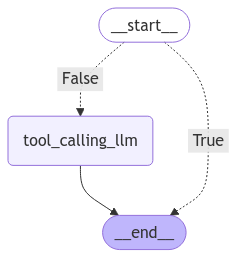

In [26]:
# build the graph
builder = StateGraph(MessagesState)

# add a node to the graph
builder.add_node('tool_calling_llm', tool_calling_llm)

# add edges to the graph
builder.add_conditional_edges(START, decide_mood, {True: END, False: 'tool_calling_llm'})
builder.add_edge('tool_calling_llm', END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke the graph

We use the `invoke` method on the graph, to execute it.

Here, we defined a graph that with the chance of 50% it uses LLM (otherwise, it does not do anything).

In [34]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?
